### Imports

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading dataset

In [4]:
df = pd.read_csv('adult.csv')

### Dropping duplicates

In [5]:
df.drop_duplicates(inplace=True)

### Dropping NaN and replacing their value

In [6]:
df.replace('?', np.nan, inplace= True)
df.dropna(subset=['occupation'], inplace=True)

native_country_mode = df['native-country'].mode()[0]
df[['native-country']] = df[['native-country']].fillna(native_country_mode)

### Fixing skewness of nummeric data

In [7]:
numeric_columns = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [8]:
from scipy.stats import yeojohnson
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
df_numeric_fixed_skew = pd.DataFrame(pt.fit_transform(df[numeric_columns]), columns=numeric_columns)

### Feature engineering

In [9]:
# America
df["native-country"] = df["native-country"].replace(['United-States'], 'US')

# Europe
df["native-country"] = df["native-country"].replace(['Greece','Holand-Netherlands','Poland',"England","Yugoslavia",
                                                        "Germany","Italy","Ireland","Hungary","France","Scotland",
                                                        "Portugal"], 'Europe')

# Asia
df["native-country"] = df["native-country"].replace(['Vietnam','China','Taiwan',"India","Philippines","Japan",
                                                        "Hong","Cambodia","Laos","Thailand"], 'Asia')

# Others
df["native-country"] = df["native-country"].replace(['Mexico','Trinadad&Tobago','Canada',"Puerto-Rico",
                                                        "Honduras","Cuba","Peru","Nicaragua","Dominican-Republic",
                                                        "Haiti","El-Salvador","Columbia","Guatemala","Jamaica","Ecuador",
                                                        "Outlying-US(Guam-USVI-etc)","Iran"], 'Others')


In [10]:
df["marital-status"] = df["marital-status"].replace(['Divorced','Separated','Widowed'], 'Single')
df["marital-status"] = df["marital-status"].replace(['Married-civ-spouse','Married-spouse-absent',
                                                         'Married-AF-spouse'], 'Married')

In [11]:
df["relationship"] = df["relationship"].replace(['Not-in-family','Other-relative'], 'Separated')
df["relationship"] = df["relationship"].replace(['Husband','Wife'], 'Married')
df["relationship"] = df["relationship"].replace(['Unmarried','Own-child'], 'Single')

In [12]:
df["race"] = df["race"].replace(['Asian-Pac-Islander','Amer-Indian-Eskimo','Other'], 'Other')

In [13]:
df["workclass"] = df["workclass"].replace(['Self-emp-not-inc','Local-gov',"State-gov","Self-emp-inc","Federal-gov",
                                              "Without-pay","Never-worked"], 'govermental')

In [14]:
df["education"] = df["education"].replace(['Prof-school',"Assoc-acdm","Assoc-voc"], 'high-school')
df["education"] = df["education"].replace(['Some-college','Doctorate','Bachelors',"Masters"], 'college')
df["education"] = df["education"].replace(['7th-8th','10th','11th',"1st-4th","5th-6th","12th",
                                              "9th","Preschool"], 'pre-hs')


### Encoding non-numerical data

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_object = df.select_dtypes(exclude=[np.number]).reset_index()
df_object.drop('index', inplace=True, axis = 1)
object_columns = [col for col in df_object.columns]

for col in df_object:
    df_object[col] = le.fit_transform(df_object[col])

### Concatenating object and numeric data

In [16]:
df_cleaned = pd.merge(df_numeric_fixed_skew, df_object, left_index=True, right_index=True)

## Modelling

In [17]:
x = df_cleaned.drop(['income', 'educational-num'], axis = 1)
y = df_cleaned[['income']].values.ravel()

### Target split

In [20]:
df_cleaned['income'].value_counts()

income
0    34569
1    11416
Name: count, dtype: int64

### Splitting train test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, stratify=y)

### Using SMOTE to help reduce effect of imbalance

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

### Function to display metrics of Model

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, ConfusionMatrixDisplay

def metrics(y_true, y_pred):
    print(f"accuracy : {accuracy_score(y_true, y_pred)}" )
    print(f"recall : {recall_score(y_true, y_pred)}" )
    print(f"precision : {precision_score(y_true, y_pred)}" )
    print(f"f1 : {f1_score(y_true, y_pred)}" )
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### Function to display ROC Curve 

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def ROC(y_test, y_scores):
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_scores))
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

accuracy : 0.7760285291815257
recall : 0.8563419761737912
precision : 0.5302668691690171
f1 : 0.6549644914913574


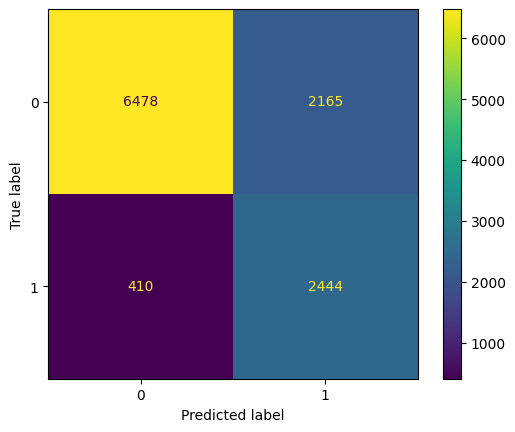

In [ ]:
knn = KNeighborsClassifier(n_neighbors=29, 
                           metric='euclidean', 
                           weights='distance')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
metrics(y_test, y_pred)

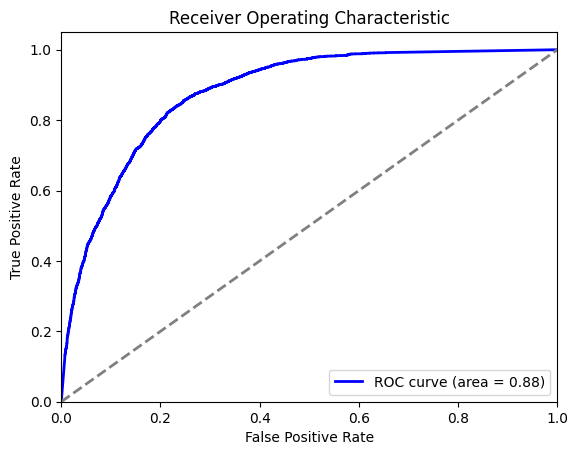

In [ ]:
y_scores = knn.predict_proba(x_test)[:, 1]
ROC(y_test, y_scores)

### SVM

In [ ]:
from sklearn.svm import SVC

accuracy : 0.7790728016004175
recall : 0.8626489138051857
precision : 0.5340563991323211
f1 : 0.6596998928188639


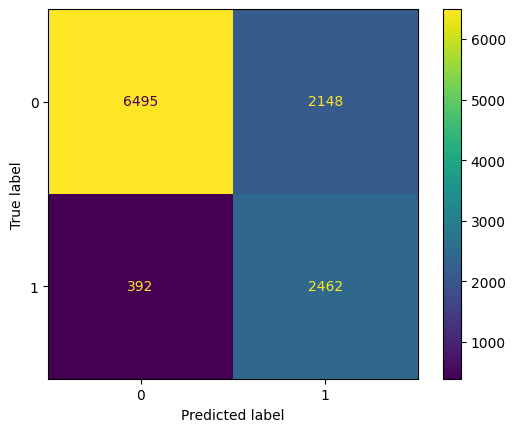

In [ ]:
svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
metrics(y_test, y_pred)

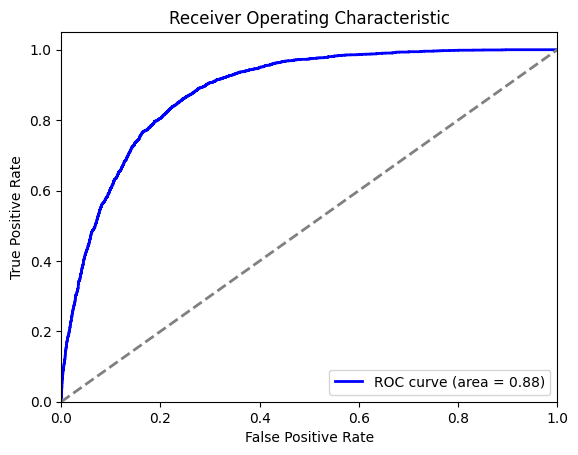

In [ ]:
y_scores = svc.decision_function(x_test)
ROC(y_test, y_scores)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

accuracy : 0.7862050969818214
recall : 0.650665732305536
precision : 0.5596745027124774
f1 : 0.601749837977965


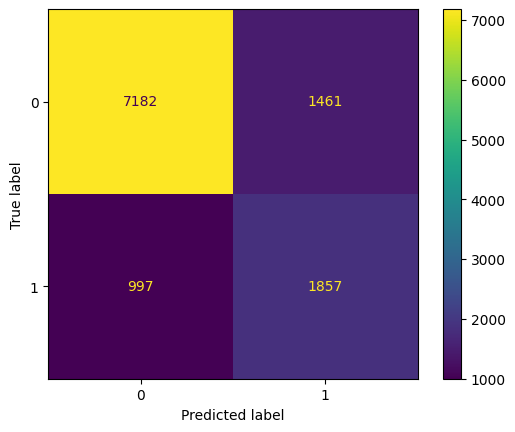

In [ ]:
DecTree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=10,
    min_samples_split=5,
    splitter='random'
)
DecTree.fit(x_train, y_train)
y_pred = DecTree.predict(x_test)
metrics(y_test, y_pred)

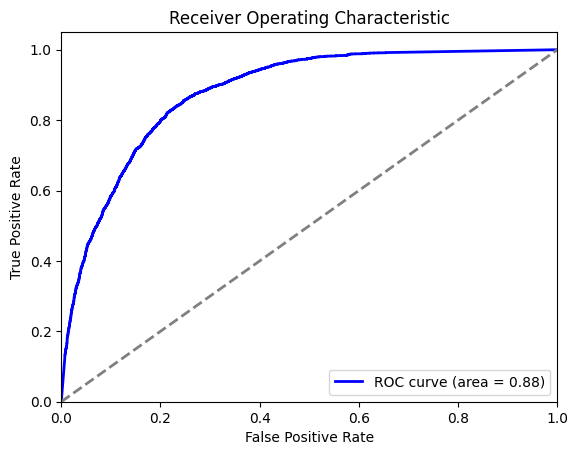

In [ ]:
y_scores = knn.predict_proba(x_test)[:, 1]
ROC(y_test, y_scores)